In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_predict
from prophet import Prophet

In [2]:
train = pd.read_csv("DailyDelhiClimateTrain.csv")
test = pd.read_csv("DailyDelhiClimateTest.csv")

In [3]:
train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [4]:
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [5]:
train['date'] =pd.to_datetime(train['date'], format = '%Y/%m/%d')
type(train['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
dict = {}
for i in list(train.columns):
    dict[i] = (train[i].isnull().sum(),round(train[i].isnull().sum()/len(train)*100,2))
pd.DataFrame(dict,index=["# of missing values","% of missing values"]).transpose().sort_values(by=["# of missing values"], ascending=False)

,# of missing values,% of missing values
date,0.0,0.0
meantemp,0.0,0.0
humidity,0.0,0.0
wind_speed,0.0,0.0
meanpressure,0.0,0.0


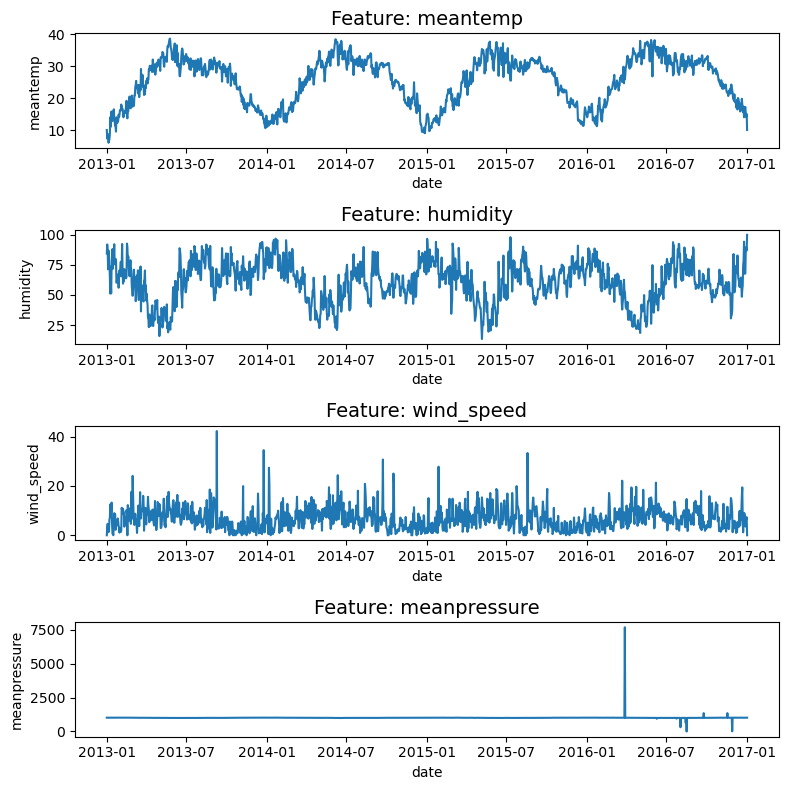

In [7]:
fix,ax = plt.subplots(nrows = 4, ncols=1, figsize=(8,8))
for i, col in enumerate(train.drop('date',axis=1).columns):
    sns.lineplot(x=train['date'],y=train[col],ax=ax[i])
    ax[i].set_title('Feature: {}'.format(col), fontsize=14)
    ax[i].set_ylabel(ylabel=col, fontsize=10)
plt.tight_layout()

### Meanpressure there are some outliers around 2016-01 to 2017-01. Apart from meanpressure rest all features seems to be stationary

In [8]:
def replace_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    
    df_in.loc[(train[col_name]<q1-1.5*iqr) | (train[col_name]>q3 + 1.5*iqr),col_name] = np.nan
    
    return df_in

In [9]:
mean_pre = replace_outliers(train,'meanpressure' ) 

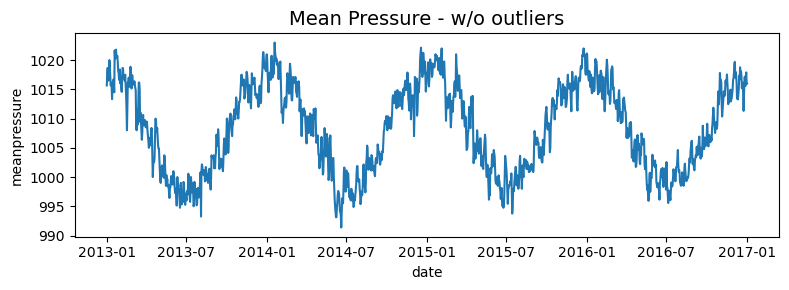

In [10]:
fig, ax =plt.subplots(figsize=(8,3)) 
ax.set_title('Mean Pressure - w/o outliers', size=14)
sns.lineplot(data=mean_pre,x='date',y='meanpressure')

plt.tight_layout()

In [11]:
print('Total NaN values for meanpressure',train['meanpressure'].isnull().sum())

Total NaN values for meanpressure 9


In [12]:
train['meanpressure'] = train['meanpressure'].interpolate()
train_lstm = train

In [13]:
print('Total NaN values for meanpressure',train['meanpressure'].isnull().sum())

Total NaN values for meanpressure 0


In [14]:
downsample = train[['date',
                 'meantemp', 
                 'humidity',
                 'wind_speed', 
                 'meanpressure'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

train1 = downsample.copy()

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [15]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=train1['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

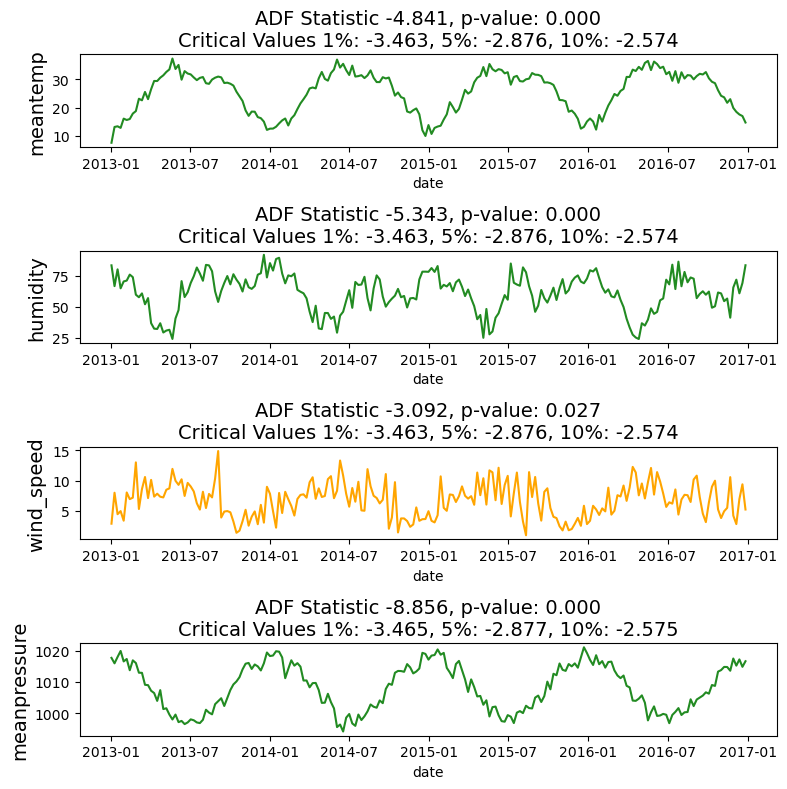

In [16]:
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(8,8))

visualize_adfuller_results(train1['meantemp'].values, 'meantemp', ax[0])
visualize_adfuller_results(train1['humidity'].values, 'humidity', ax[1])
visualize_adfuller_results(train1['wind_speed'].values, 'wind_speed', ax[2])
visualize_adfuller_results(train1['meanpressure'].values, 'meanpressure', ax[3])

plt.tight_layout()

Data is stationary and does not need transformation
The two most common methods to transform series into stationarity ones are:

Transformation: e.g. log or square root to stabilize non-constant variance
Differencing: subtracts the current value from the previous

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seasonality: The repeating short-term cycle in the series.
Noise: The random variation in the series.
Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.


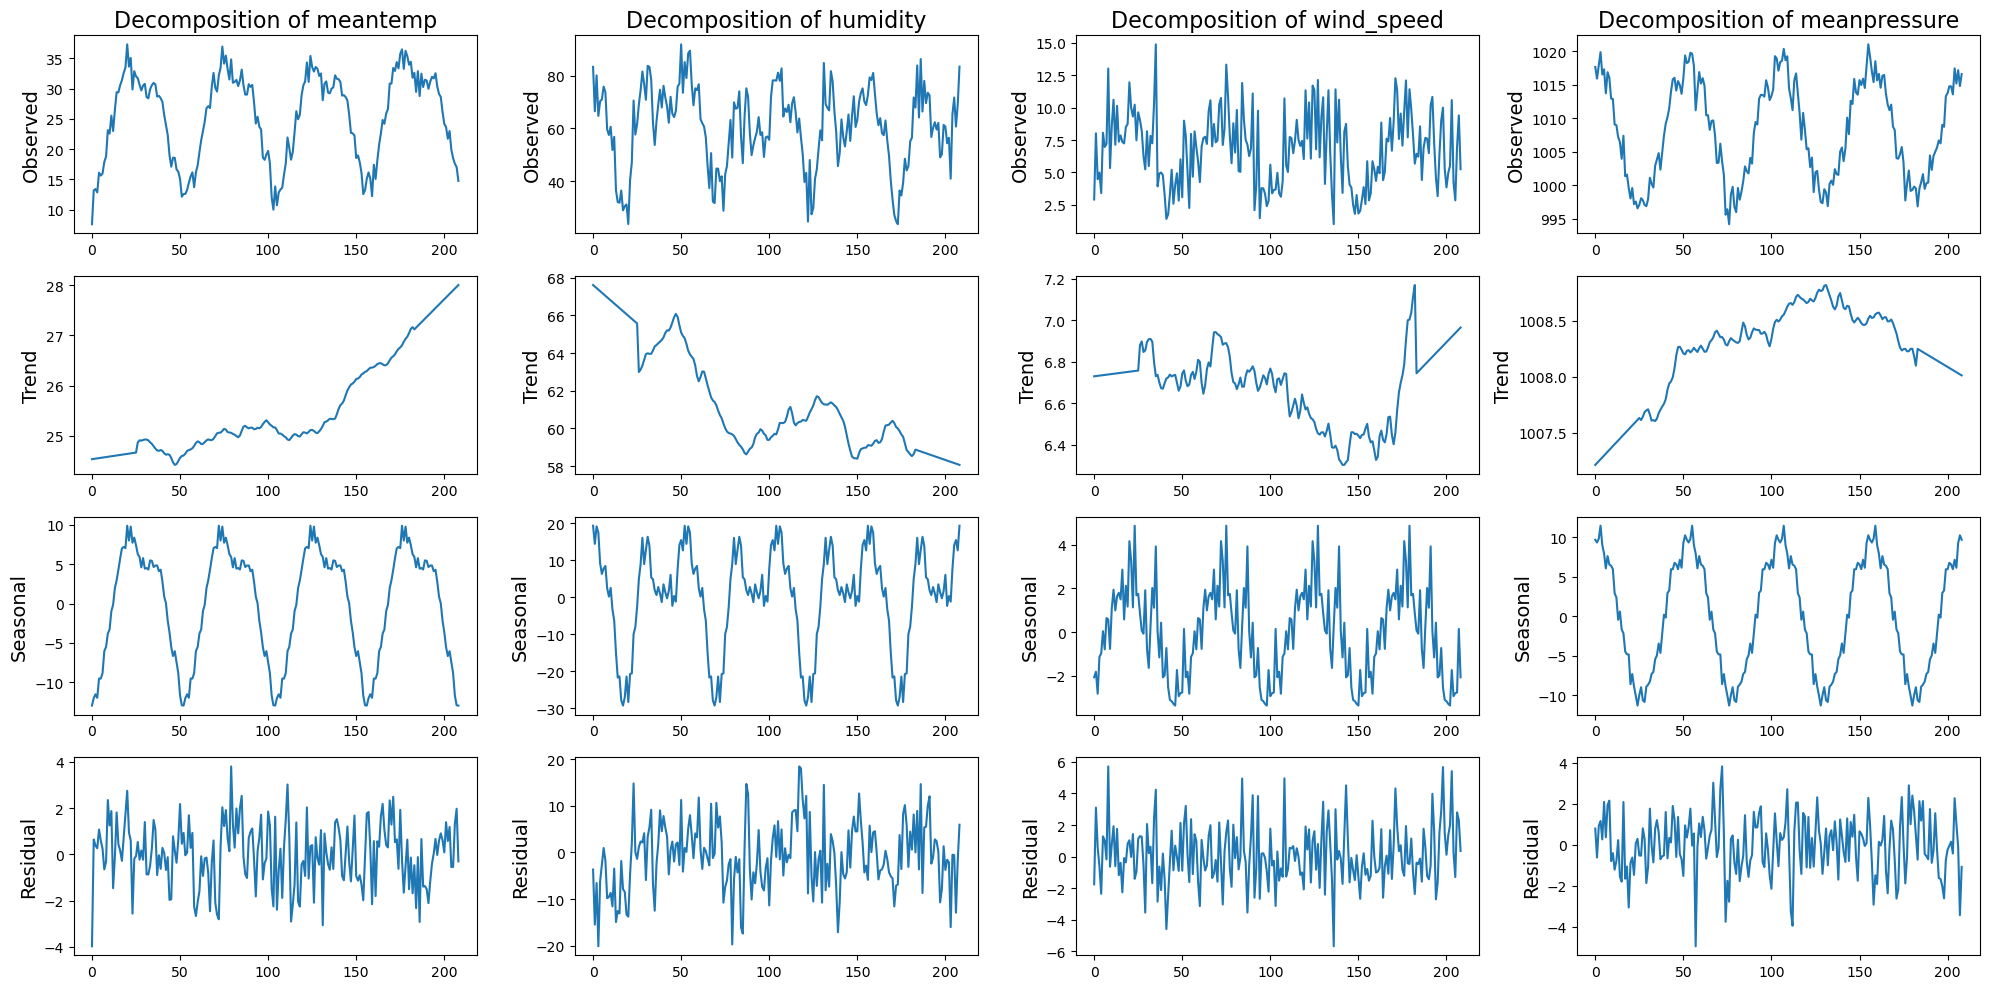

In [17]:
columns=['meantemp','humidity','wind_speed','meanpressure']

fig, ax =plt.subplots(nrows=4,ncols=4,figsize=(20,10))

for i, column in enumerate(columns):
    
    res = seasonal_decompose(train1[column], period=52, model='additive', extrapolate_trend='freq')
    
    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False)
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False)
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False)
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False)
    ax[3,i].set_ylabel('Residual', fontsize=14)
    
plt.tight_layout()

We can observe that the trends show very little variation across all features, while seasonality is prominent in all features.

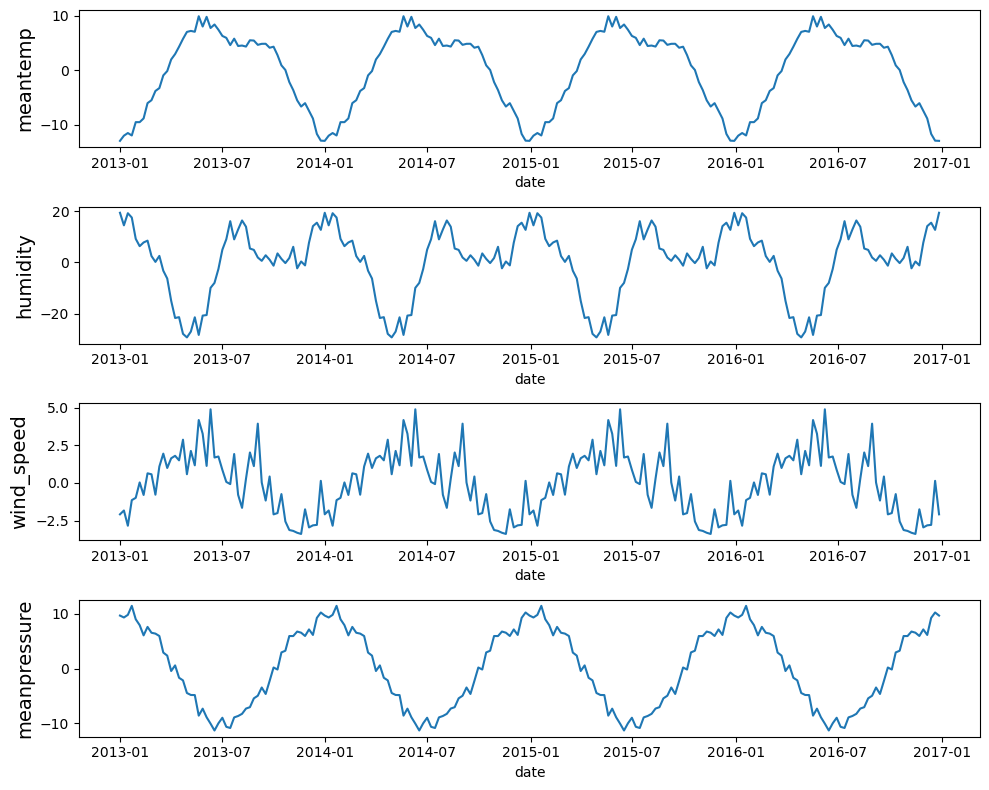

In [18]:
for column in columns:
    decomp = seasonal_decompose(train1[column], period=52, model='additive', extrapolate_trend='freq')
    train1[f"{column}_trend"] = decomp.trend
    train1[f"{column}_seasonal"] = decomp.seasonal
    
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,8))

for i, column in enumerate(columns):
    sns.lineplot(x=train1['date'], y=train1[column + '_seasonal'], ax=ax[i])
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    
plt.tight_layout()

## Univariate time series forecasts using ARIMA

In [19]:
univariate_df=train1[['date', 'humidity']].copy()
univariate_df.columns = ['ds', 'y']

In [20]:
train_size = int(0.85 * len(train1))

In [21]:
train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

In [22]:
model = pm.auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1967.723, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1290.991, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1773.679, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1283.688, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1285.465, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1285.565, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1640.820, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1285.634, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1274.339, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1380.066, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1276.393, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1275.003, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1275.369, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

In [23]:
model = ARIMA(y_train, order=(2,0,0),trend='c')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  177
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -632.823
Date:                Fri, 17 May 2024   AIC                           1273.646
Time:                        10:30:00   BIC                           1286.350
Sample:                             0   HQIC                          1278.798
                                - 177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.4300      4.365     13.844      0.000      51.874      68.986
ar.L1          0.6978      0.073      9.533      0.000       0.554       0.841
ar.L2          0.1650      0.070      2.342      0.0

In [24]:
y_pred = model_fit.forecast(32)

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 13.41555210841573


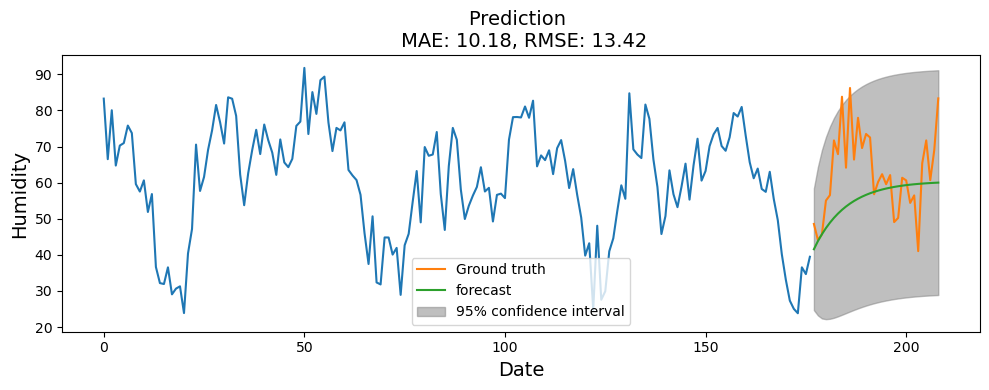

In [25]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, label='Ground truth') 
plot_predict(model_fit,177, 208, ax=ax)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Humidity', fontsize=14)

plt.tight_layout()

## Multivariate time series forecasts using ARIMAX

In [26]:
train1.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure',
       'meantemp_trend', 'meantemp_seasonal', 'humidity_trend',
       'humidity_seasonal', 'wind_speed_trend', 'wind_speed_seasonal',
       'meanpressure_trend', 'meanpressure_seasonal'],
      dtype='object')

In [27]:
exogenous_features = [ 'meantemp', 'wind_speed', 'meanpressure',]

In [28]:
model = SARIMAX(y_train, order=(2,0,0),exogenous=train1[exogenous_features],trend='c')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  177
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -632.823
Date:                Fri, 17 May 2024   AIC                           1273.646
Time:                        10:30:01   BIC                           1286.350
Sample:                             0   HQIC                          1278.798
                                - 177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.2852      2.618      3.165      0.002       3.154      13.416
ar.L1          0.6978      0.073      9.533      0.000       0.554       0.841
ar.L2          0.1650      0.070      2.342      0.0

In [29]:
y_pred = model_fit.forecast(32)

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 13.438355796851264


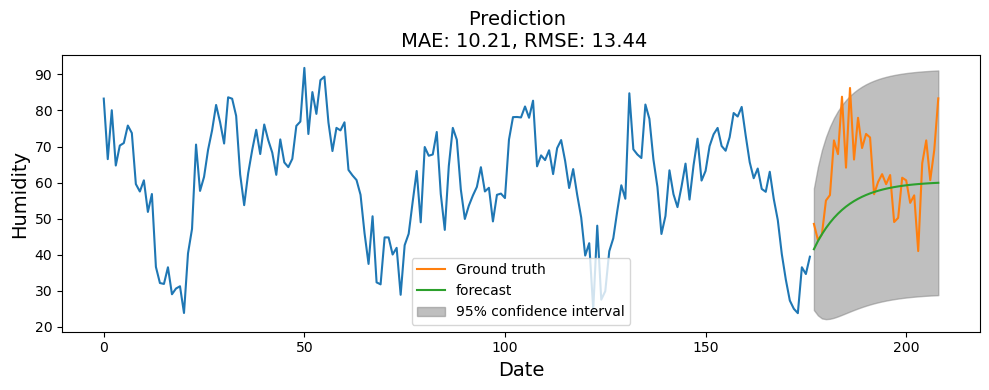

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, label='Ground truth') 
plot_predict(model_fit,177, 208, ax=ax)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Humidity', fontsize=14)

plt.tight_layout()

## Multivariate time series forecasts using Prophet

In [31]:
features= ['meantemp',
          'wind_speed',
          'meanpressure']

target=['humidity']

multivariate_df= train1[['date'] + target + features].copy()
multivariate_df.columns = ['ds', 'y'] + features

multivariate_df.head(5).append(multivariate_df.tail(5))

C:\Users\DELL\AppData\Local\Temp\ipykernel_10612\741708971.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  multivariate_df.head(5).append(multivariate_df.tail(5))


,ds,y,meantemp,wind_speed,meanpressure
0,2013-01-01,83.295238,7.604762,2.903810,1017.685714
1,2013-01-08,66.511905,13.176871,8.013265,1015.942177
2,2013-01-15,80.068027,13.409524,4.471905,1017.972789
3,2013-01-22,64.748299,12.848639,4.981973,1019.884694
4,2013-01-29,70.279592,16.107653,3.396378,1016.554592
204,2016-11-29,65.384536,19.883387,4.234881,1017.473212
205,2016-12-06,71.711197,18.500047,2.837198,1015.210392
206,2016-12-13,60.698526,17.578005,6.974330,1017.191007
207,2016-12-20,69.026283,17.020965,9.403279,1014.833210
208,2016-12-27,83.352881,14.742226,5.245749,1016.612457


In [32]:
train = multivariate_df.iloc[:train_size, :]
x_train_p, y_train_p = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid_p, y_valid_p = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

In [33]:
model_p = Prophet()
model_p.add_regressor('meantemp')
model_p.add_regressor('wind_speed')
model_p.add_regressor('meanpressure')

# Fit the model with train set
model_p.fit(train)

# Predict on valid set
y_pred_p = model_p.predict(x_valid_p)
%store y_pred_p
# Calcuate metrics
score_mae = mean_absolute_error(y_valid_p, y_pred_p['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid_p, y_pred_p['yhat']))

print('RMSE: {}'.format(score_rmse))

10:30:03 - cmdstanpy - INFO - Chain [1] start processing
10:30:03 - cmdstanpy - INFO - Chain [1] done processing


Stored 'y_pred_p' (DataFrame)
RMSE: 6.209540598920954


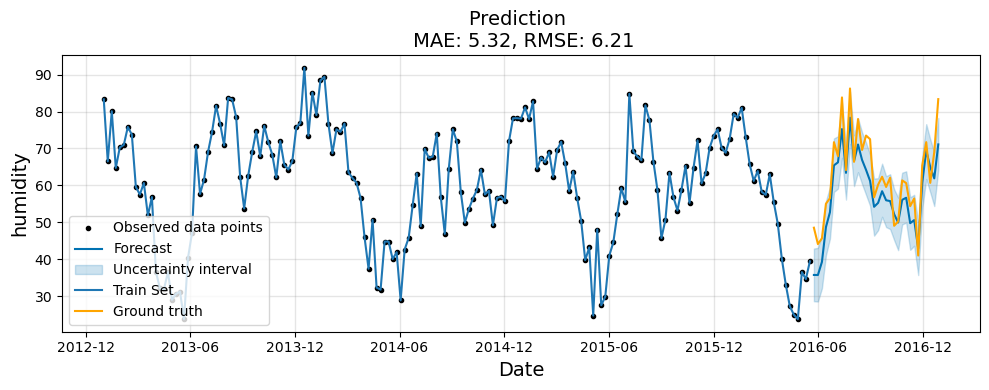

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))

model_p.plot(y_pred_p, ax=ax)
sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, label='Train Set')
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='humidity', fontsize=14)

plt.tight_layout()

## LSTM

In [35]:
n_cols = 1
dataset = train_lstm["humidity"]
dataset = pd.DataFrame(dataset)
data = dataset.values
data.shape

(1462, 1)

In [36]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))
scaled_data

array([[0.8209571 ],
       [0.90759076],
       [0.84983498],
       ...,
       [0.88063806],
       [0.84983498],
       [1.        ]])

In [38]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 1)

In [39]:
x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])
    if i<=time_steps:
        print('X_train: ', x_train)
        print('y_train:' , y_train)

X_train:  [array([[0.8209571 ],
       [0.90759076],
       [0.84983498],
       [0.66886689],
       [0.84790979],
       [0.80132013],
       [0.75280528],
       [0.58085809],
       [0.43688119],
       [0.56105611],
       [0.43729373],
       [0.69966997],
       [0.71314631],
       [0.86331133],
       [0.67491749],
       [0.8459846 ],
       [0.77860286],
       [0.90951595],
       [0.73047305],
       [0.71452145],
       [0.73432343],
       [0.76512651],
       [0.53987899],
       [0.54565457],
       [0.61881188],
       [0.58608361],
       [0.60231023],
       [0.49174917],
       [0.60148515],
       [0.65841584],
       [0.60264026],
       [0.68811881],
       [0.74092409],
       [0.60231023],
       [0.7029703 ],
       [0.91192244],
       [0.66886689],
       [0.5310231 ],
       [0.65841584],
       [0.55280528],
       [0.67079208],
       [0.65924092],
       [0.65731573],
       [0.65511551],
       [0.58223322],
       [0.59955996],
       [0.91584158],
  

In [40]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [41]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [42]:
x_train.shape , y_train.shape

((1402, 60, 1), (1402, 1))

In [43]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

Using TensorFlow backend


In [44]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, n_cols)),
    LSTM(64, activation='relu'),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
history = model.fit(x_train, y_train, epochs=100, batch_size= 32)

Epoch 1/100
44/44 [==============================] - 8s 84ms/step - loss: 0.0514 - mean_absolute_error: 0.1678
Epoch 2/100
44/44 [==============================] - 3s 69ms/step - loss: 0.0169 - mean_absolute_error: 0.1041
Epoch 3/100
44/44 [==============================] - 3s 58ms/step - loss: 0.0152 - mean_absolute_error: 0.0979
Epoch 4/100
44/44 [==============================] - 3s 60ms/step - loss: 0.0150 - mean_absolute_error: 0.0972
Epoch 5/100
44/44 [==============================] - 2s 56ms/step - loss: 0.0145 - mean_absolute_error: 0.0956
Epoch 6/100
44/44 [==============================] - 2s 56ms/step - loss: 0.0142 - mean_absolute_error: 0.0941
Epoch 7/100
44/44 [==============================] - 3s 62ms/step - loss: 0.0136 - mean_absolute_error: 0.0918
Epoch 8/100
44/44 [==============================] - 2s 54ms/step - loss: 0.0133 - mean_absolute_error: 0.0909
Epoch 9/100
44/44 [==============================] - 3s 57ms/step - loss: 0.0132 - mean_absolute_error: 0.0900
E

44/44 [==============================] - 2s 55ms/step - loss: 0.0079 - mean_absolute_error: 0.0669
Epoch 75/100
44/44 [==============================] - 2s 55ms/step - loss: 0.0082 - mean_absolute_error: 0.0683
Epoch 76/100
44/44 [==============================] - 2s 53ms/step - loss: 0.0082 - mean_absolute_error: 0.0685
Epoch 77/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0082 - mean_absolute_error: 0.0681
Epoch 78/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0083 - mean_absolute_error: 0.0692
Epoch 79/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0083 - mean_absolute_error: 0.0688
Epoch 80/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0083 - mean_absolute_error: 0.0692
Epoch 81/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0080 - mean_absolute_error: 0.0676
Epoch 82/100
44/44 [==============================] - 3s 60ms/step - loss: 0.0079 - mean_absolute_error: 0.0668
Epoch

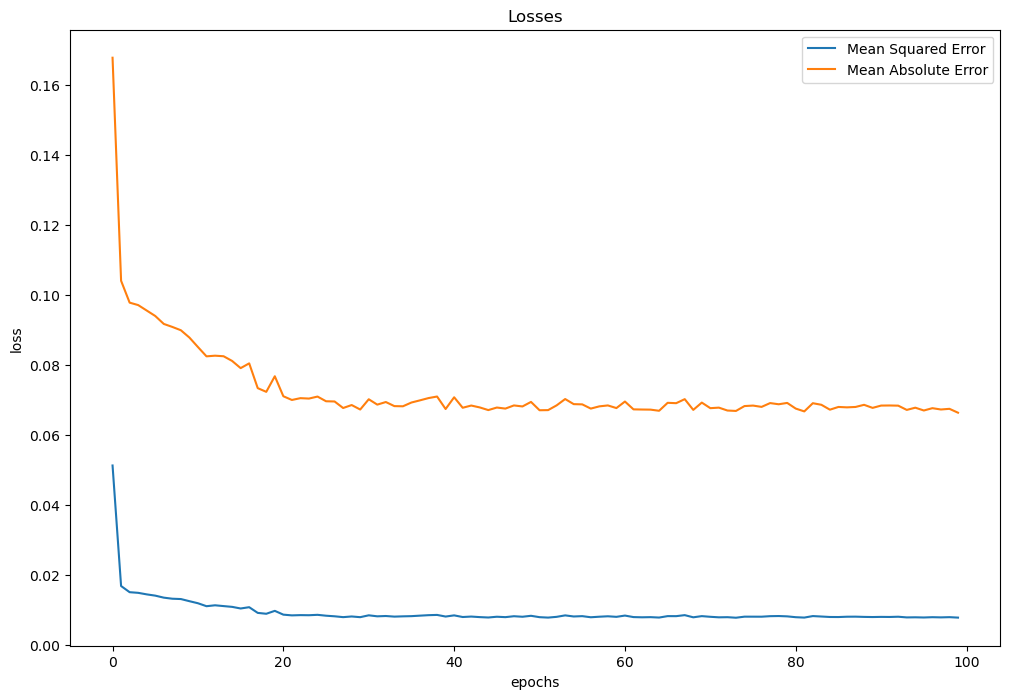

In [47]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [48]:
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [49]:
x_test.shape, y_test.shape

((366, 60, 1), (366, 1))

In [50]:
predictions = model.predict(x_test)

12/12 [==============================] - 1s 22ms/step


In [51]:
predictions.shape

(366, 1)

In [52]:
predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [53]:
y_test = scaler.inverse_transform(y_test)
y_test.shape

(366, 1)

In [54]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.03

In [55]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,71.589287,75.875000
1,74.188576,74.750000
2,73.260674,77.125000
3,75.300262,88.833333
4,82.581482,81.625000
...,...,...
361,66.752861,68.043478
362,68.585320,87.857143
363,82.067421,89.666667
364,81.980659,87.000000


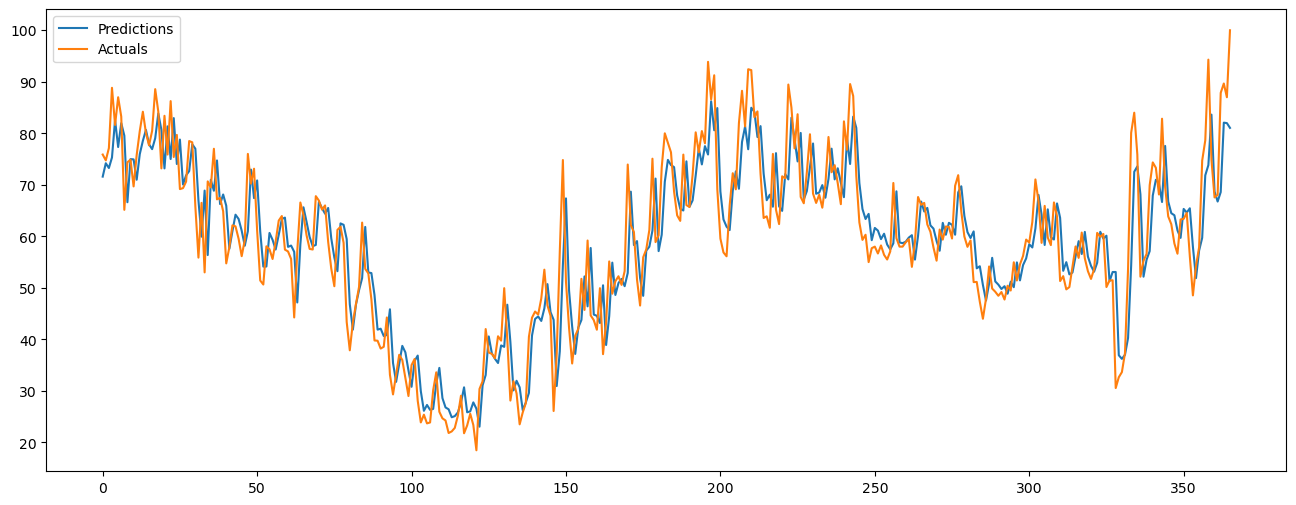

In [56]:
plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()